# Ktransit...

Note that I find ktransit to be temperamental at best, but it is the only package that will fit data out of the box.

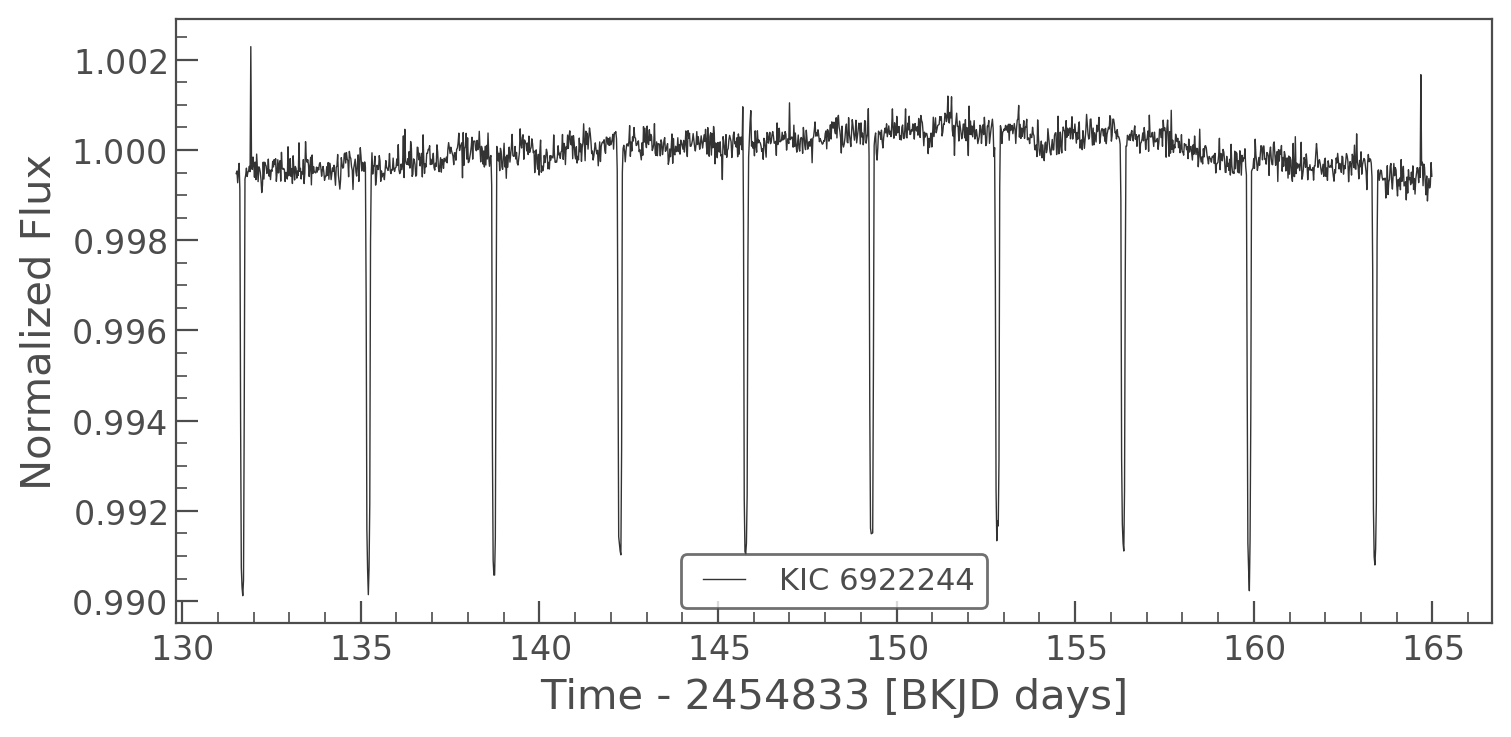

In [44]:
from lightkurve import KeplerLightCurveFile
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import batman

lcf = KeplerLightCurveFile.from_archive('Kepler-8', quality_mask='hard', quarter=1)
lc = lcf.PDCSAP_FLUX.remove_nans().normalize()
lc.plot()

In [45]:
import astropy.units as u
from astropy.constants import G
teff = lcf.header()['TEFF']
logg = lcf.header()['LOGG']
feh = lcf.header()['FEH']
r= lcf.header()['RADIUS']*u.solRad

g = 10.**(logg)*(u.cm/u.second**2)
m = ((g*r**2)/G).to(u.solMass)

In [46]:
from PyAstronomy import pyasl
import astropy.units as u
nexa = pyasl.NasaExoplanetArchive()
planet = nexa.selectByPlanetName('kepler-8 b')

# Planet Period
per = planet['pl_orbper']

# Transit midpoint
t0 = planet['pl_tranmid'] - 2454833.0

In [47]:
rp_init = ((np.median(lc.flux) - np.min(lc.flux)) / np.median(lc.flux))**0.5
i_init = 90
d = (((per*u.day).to(u.second))**2 * G * m / (4*np.pi**2))**(1./3.)
a_init = (d.to(u.solRad)/r).value

In [48]:
from ktransit import FitTransit
import ktransit

In [49]:
fitT = FitTransit()
fitT.add_guess_star(rho=1.5)    
fitT.add_guess_planet(
        period=per, impact=0.0, 
        T0=t0, rprs=rp_init)
fitT.add_data(time=lc.time, flux=lc.flux - 1, ferr=lc.flux_err)

vary_star = ['rho', 'zpt']      # free stellar parameters
vary_planet = (['period', 'impact', 'rprs'])                # free planet parameters are the same for every planet you model

fitT.free_parameters(vary_star, vary_planet)
fitT.do_fit()                   # run the fitting

fitT.print_results()            # print some results

Best-fitting stellar parameters
rho: 1.5
zpt: 0.0

Best-fitting planet parameters for planet 0
period: 3.5224991
impact: 0.0
rprs: 0.0993988205292876



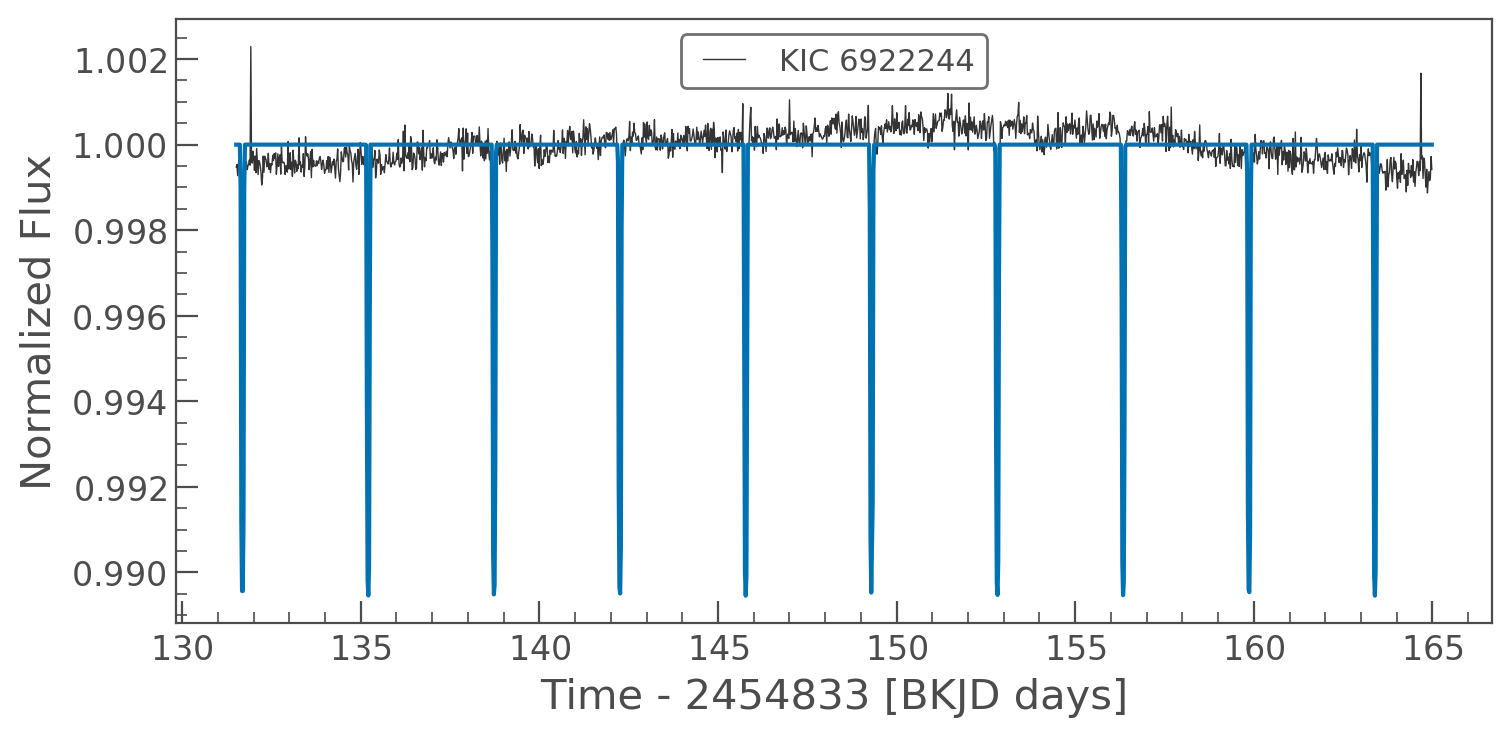

In [50]:
ax = lc.plot()
ax.plot(lc.time, fitT.transitmodel + 1)